In [5]:
import torch
import wandb
from hydra import compose, initialize
from hydra.utils import instantiate
from metalearning_benchmarks import MetaLearningBenchmark
from torch.utils.data import DataLoader
import os

from src.components.contextual_dvi import ContextualDVI
from src.components.control import Control
from src.components.decoder import Decoder
from src.components.dvi_process import DiffusionVIProcess
from src.components.encoder import SetEncoder
from src.components.hyper_net import HyperNet
from src.utils.context_datasets import MetaLearningDataset
from src.utils.visualize import visualize

In [2]:
try:
    import torch_directml
    device = torch_directml.device() 
except ImportError:
    device = torch.device("cpu") 
print(device)

privateuseone:0


In [3]:
dir = "../models/control-cross-attn"

In [6]:
with initialize(version_base=None, config_path=dir):
    config = compose(config_name="config")

    benchmark: MetaLearningBenchmark = instantiate(config.benchmark.value)
    dataset = MetaLearningDataset(benchmark=benchmark)
    dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)

    set_encoder = SetEncoder(
        c_dim=config.common.value.c_dim,
        h_dim=config.common.value.h_dim,
        num_layers=config.common.value.num_layers,
        non_linearity=config.common.value.non_linearity,
        is_attentive=config.set_encoder.value.is_attentive,
        is_aggregative=not config.control_and_hyper_net.value.is_cross_attentive
        or not config.decoder.value.is_cross_attentive,
        is_non_aggregative=config.control_and_hyper_net.value.is_cross_attentive
        or config.decoder.value.is_cross_attentive,
        use_context_size=config.set_encoder.value.use_context_size,
        aggregation=config.set_encoder.value.aggregation,
        max_context_size=dataset.max_context_size,
    )

    control = Control(
        h_dim=config.common.value.h_dim,
        z_dim=config.common.value.z_dim,
        num_layers=config.common.value.num_layers,
        non_linearity=config.common.value.non_linearity,
        num_steps=config.dvi_process.value.num_steps,
        is_cross_attentive=config.control_and_hyper_net.value.is_cross_attentive,
        num_heads=config.control_and_hyper_net.value.num_heads,
    )

    hyper_net = (
        HyperNet(
            config.common.value.h_dim,
            config.common.value.z_dim,
            config.common.value.non_linearity,
            config.dvi_process.value.num_steps,
            config.control_and_hyper_net.value.is_cross_attentive,
            config.control_and_hyper_net.value.num_heads,
        )
        if config.control_and_hyper_net.value.use_hyper_net
        else None
    )

    dvi_process: DiffusionVIProcess = instantiate(
        config.dvi_process.value,
        z_dim=config.common.value.z_dim,
        control=control,
        hyper_net=hyper_net,
        device=device,
    )

    decoder = Decoder(
        x_dim=config.common.value.x_dim,
        z_dim=config.common.value.z_dim,
        h_dim=config.common.value.h_dim,
        y_dim=config.common.value.y_dim,
        num_layers=config.common.value.num_layers,
        non_linearity=config.common.value.non_linearity,
        has_lat_path=config.decoder.value.has_lat_path,
        has_det_path=config.decoder.value.has_det_path,
        is_cross_attentive=config.decoder.value.is_cross_attentive,
    )

    contextual_dvi = ContextualDVI(
        encoder=set_encoder,
        dvi_process=dvi_process,
        decoder=decoder,
    ).to(device)

    path = f"{dir}/contextual_dvi.pth"
    if os.path.exists(path):
        state_dict = torch.load(path, map_location=torch.device("cpu"), weights_only=True)
        contextual_dvi.load_state_dict(state_dict)
        print(f"Loaded model from {path}")

Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 281956.13it/s]


/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/torch/distributions/normal.py:71: UserWarning: The operator 'aten::normal.Tensor_Tensor' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  return torch.normal(self.loc.expand(shape), self.scale.expand(shape))


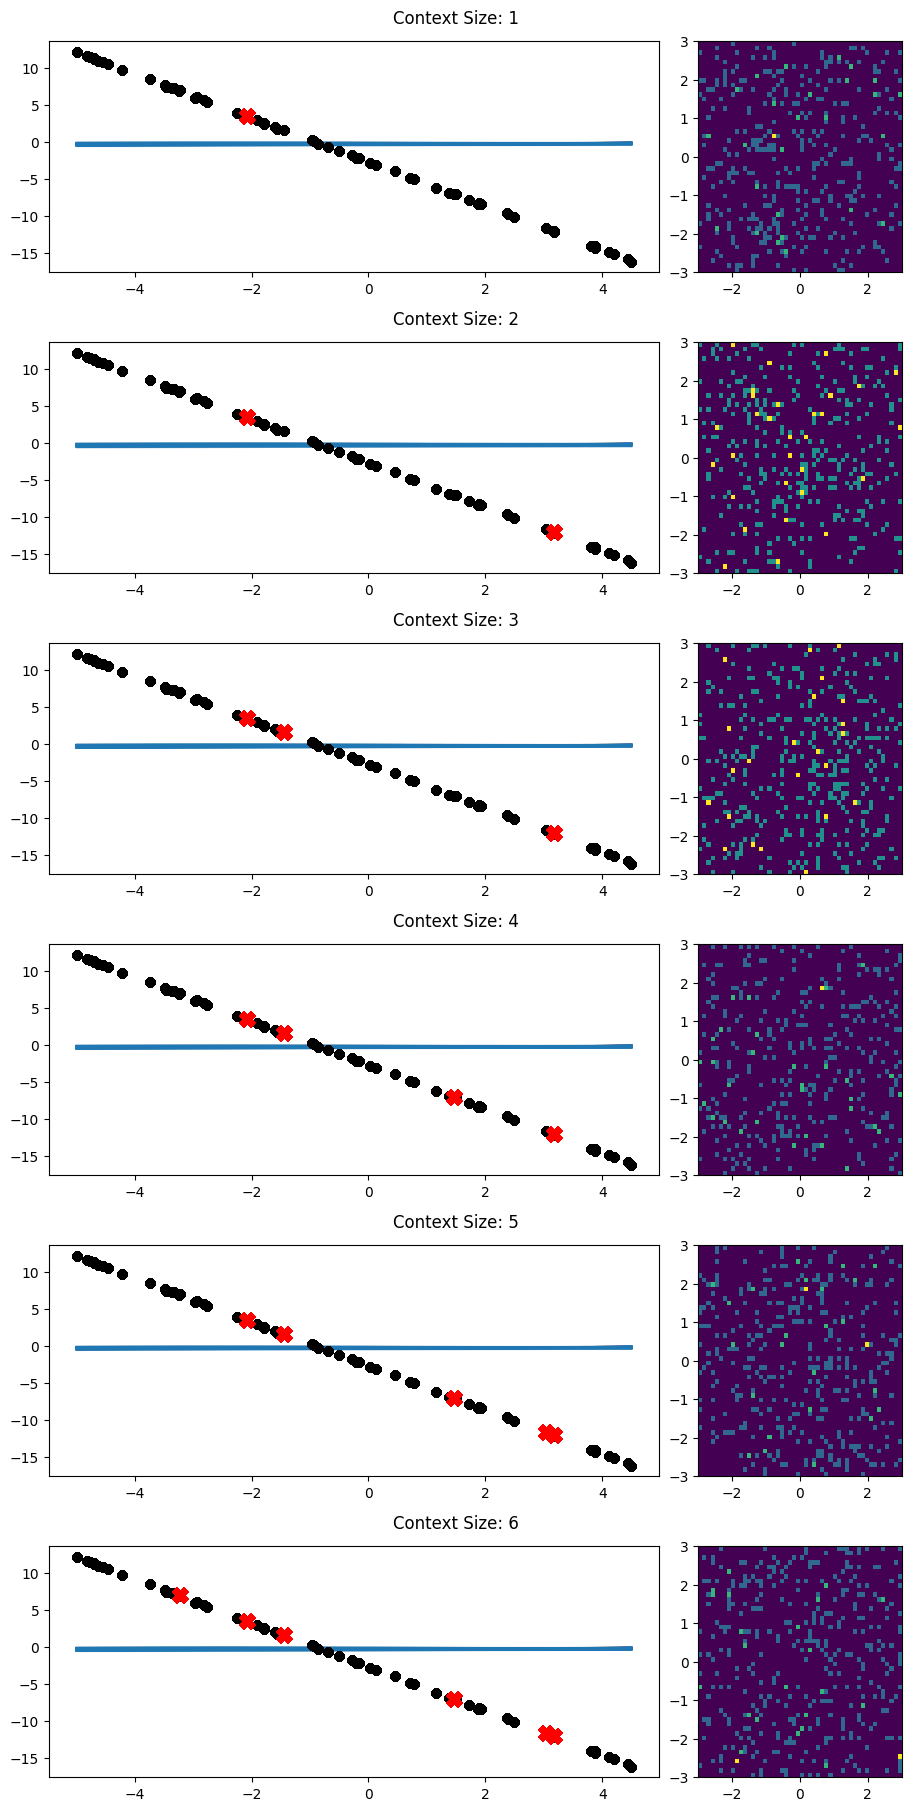

In [7]:
max_context_size = 6
num_samples = 1024

visualize(
    device=device,
    dvi_process=dvi_process,
    set_encoder=set_encoder,
    decoder=decoder,
    dataloader=dataloader,
    control=control,
    config=config,
    num_samples=num_samples,
    max_context_size=max_context_size
)